In [1]:
library(ggmap,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(sp,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(maptools,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(viridis,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(rgeos,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(rgdal,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(magrittr,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(GISTools,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(data.table,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(tidyverse,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(spdep,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(CARBayes,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(caret,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(coda, warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(leaflet,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Checking rgeos availability: TRUE

rgeos version: 0.5-3, (SVN revision 634)
 GEOS runtime version: 3.8.0-CAPI-1.13.1 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 


rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/local/gdal-3.1.2/share/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
Path to PROJ shared files: /usr/local/proj-6.1.0/share/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.

In [2]:
library(showtext)
font_add_google('Nanum Pen Script', 'nanumpen')
showtext_auto()

Loading required package: sysfonts

Loading required package: showtextdb



# 1. 데이터 불러오기

In [3]:
data_16 <- readOGR("16.용인시_소상공인_매출정보.geojson",encoding = 'UTF-8')
data_17 <- fread("17.용인시_소상공인_매출정보.csv",encoding = 'UTF-8', data.table = F, stringsAsFactors = F)

data_16@data$id <- rownames(data_16@data)
map_16 <- fortify(data_16,region = "id")
map_merged_16<-left_join(map_16,data_16@data, by = "id")

OGR data source with driver: GeoJSON 
Source: "/opt/app-root/src/코드/16.용인시_소상공인_매출정보.geojson", layer: "용인시_사업장정보"
with 9915 features
It has 66 fields


In [4]:
data <-fread("data_f.csv",encoding = "UTF-8", data.table = F, stringsAsFactors = F)

### 청년 사업체 수 특징 - 영과잉(Zero-Inflated)
- 일반 포아송 분포에 비해 0이 과하게 많은 형태

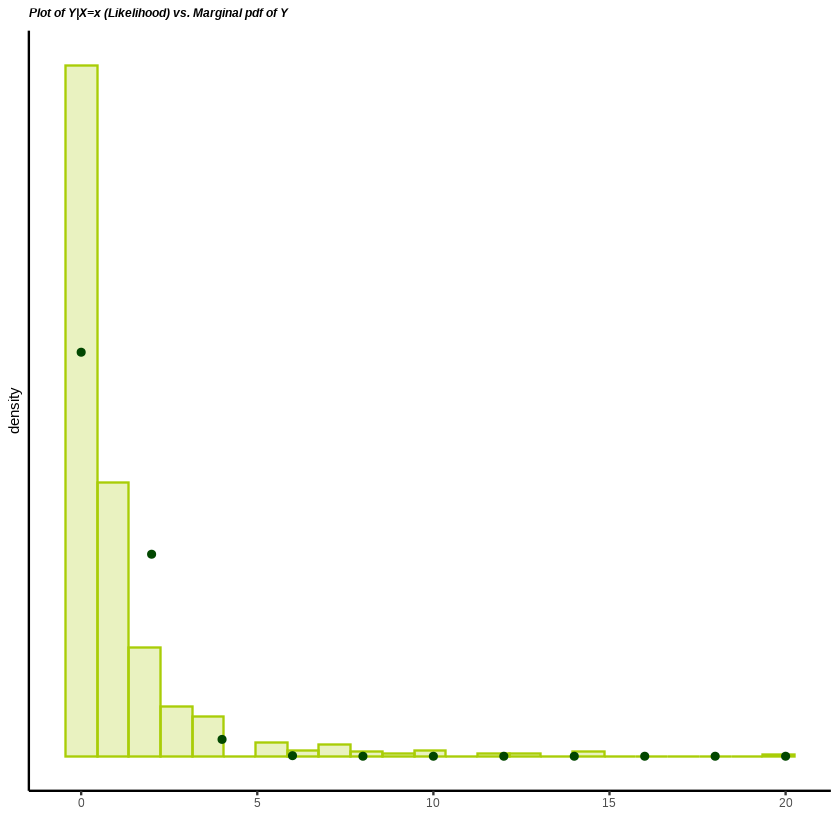

In [5]:
data$Y_youth_count%>% enframe() %>%
    ggplot(aes(x=value))+
    geom_histogram(aes(y = stat(density)),
                   fill='#a9cd07',
                   colour='#a9cd07',
                   alpha = 0.25,
                   binwidth=.9) + 
    stat_function(geom="point", n=11, fun=dpois, args=list(1),col="#014700") +
    scale_y_continuous(breaks = NULL)+
    labs(title="Plot of Y|X=x (Likelihood) vs. Marginal pdf of Y",x ="") + 
    theme_classic()+
    theme(plot.title = element_text(size=9, face="bold.italic"))

### 공간자기상관성 검정(Moran's I)
- 귀무가설(H0) : 공간 자기상관성이 없다

In [6]:
my_shp <- data_16[which(data_16$gid%in%data$gid), ] # 17번 데이터 기준 shp
my_nb <- poly2nb(my_shp, row.names = data$gid,queen = FALSE)# Rook's neighborhood
my_listw <- nb2listw(my_nb, style = "B", zero.policy = TRUE)
moran.test(data$Y_youth_count, my_listw , zero.policy = TRUE) # frequentists' moran : 유의함


	Moran I test under randomisation

data:  data$Y_youth_count  
weights: my_listw  n reduced by no-neighbour observations
  

Moran I statistic standard deviate = 11.327, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.389230994      -0.001396648       0.001189309 


- p-value가 0.05보다 작으므로 "공간 자기상관성이 없다"라는 귀무가설을 기각한다. 즉 공간 자기상관성을 고려해야한다

# 2. 모델링

### 2.1 중심좌표 계산 및 공간 가중치 행렬(Weight Matrix) 계산

In [7]:
uniq16 <-map_merged_16 %>% select(gid) %>% unique()
temp <-cbind(coordinates(data_16),uniq16)
colnames(temp) <- c("long","lat","gid")
data_17 %<>% left_join(temp, by = "gid")
cent <- data_17 %>% select(c(gid,long,lat))
data %<>% left_join(cent, by = "gid")
data1<-data %>% dplyr::select(-c(gid,Y_stable,long,lat))
set.seed(2021)
index<-createDataPartition(data1$Y_youth_count,p = .5,list = F) 
data1_strat<-data1[index,] 

- Weight Matrix : Power Distance with alpha = 2

In [8]:
# 중심좌표만 떼내기

crds <- data %>% select(c(long,lat)) %>% as.matrix()
crds <- crds[index,]

## Weight: Power Distance Weights with alpha = 1 (W = 1/W^2 )  ##

dists <- as.matrix(dist(crds))
dists.inv <- 1/(dists^2) 
diag(dists.inv) <- 0 # 본인끼리의 Weight는 0이므로 대각 요소는 0으로 바꿈

## 공간 가중치 행렬 스케일링 

max_ei <- max(dists.inv)
dists.inv <- dists.inv/max_ei

### 2.2 SZIP 모델링

#### 1. Stepwise selection을 통한 0 part 설명 변수 결정 

In [9]:
fit_logit <- glm(ifelse(Y_youth_count==0,1,0) ~ ., data = data1_strat, family = binomial(link = "logit"))
stepAIC(fit_logit, trace = F)


Call:  glm(formula = ifelse(Y_youth_count == 0, 1, 0) ~ found_mid + 
    age_4050 + loan_excess + gid_variety + ROA_CLS_SE_2, family = binomial(link = "logit"), 
    data = data1_strat)

Coefficients:
 (Intercept)     found_mid      age_4050   loan_excess   gid_variety  
     0.53696       3.10998       0.02351      -0.80383      -0.54300  
ROA_CLS_SE_2  
    -0.25677  

Degrees of Freedom: 403 Total (i.e. Null);  398 Residual
Null Deviance:	    554.3 
Residual Deviance: 428.5 	AIC: 440.5

- found_mid, age_4050, loan_excess, gid_variety, ROA_CLS_SE_2 사용

#### 2. SZIP 모델을 위한 사전 분포 계산

In [10]:
## Prior for delta

fit_logit_f <- glm(ifelse(Y_youth_count==0,1,0) ~ found_mid + age_4050 + loan_excess + gid_variety + ROA_CLS_SE_2,
                   data = data1_strat,
                   family = binomial(link = "logit"))
delta_mean_prior <- fit_logit_f %>% coef

#### 3. SZIP 모델링
- Scaling : 계수 비교를 위해 scaling
- Three Parallel Chains : global convergence 보기 위함

In [11]:
## scaling
temp <- data1_strat%>%select(-c(Y_youth_count,cluster)) %>% scale()
data1_strat <- data1_strat%>%select(c(Y_youth_count,cluster))  %>% cbind(temp)

In [12]:
## Chain 1
set.seed(1)
chain1<-S.CARbym(formula = Y_youth_count ~., 
                formula.omega = ~found_mid + loan_excess + age_4050 + ROA_CLS_SE_2 + gid_variety,
                data=data1_strat,family = "zip",prior.mean.delta=delta_mean_prior,
                burnin =50000,n.sample = 100000,thin=10, W =dists.inv,MALA = T,verbose = T)

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  479 seconds.


In [13]:
## Chain 2
set.seed(2)
chain2<-S.CARbym(formula = Y_youth_count ~., 
                formula.omega = ~found_mid + loan_excess + age_4050 + ROA_CLS_SE_2 + gid_variety,
                data=data1_strat,family = "zip",prior.mean.delta=delta_mean_prior,
                burnin =50000,n.sample = 100000,thin=10, W =dists.inv,MALA = T,verbose = T)

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  426.2 seconds.


In [14]:
## Chain 3
set.seed(3)
chain3<-S.CARbym(formula = Y_youth_count ~., 
                formula.omega = ~found_mid + loan_excess + age_4050 + ROA_CLS_SE_2 + gid_variety,
                data=data1_strat,family = "zip",prior.mean.delta=delta_mean_prior,
                burnin =50000,n.sample = 100000,thin=10, W =dists.inv,MALA = T,verbose = T)

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  415.8 seconds.


#### 4. 계수 수렴 확인 및 계수값 확인

- beta (used for poisson regression: positive counts)

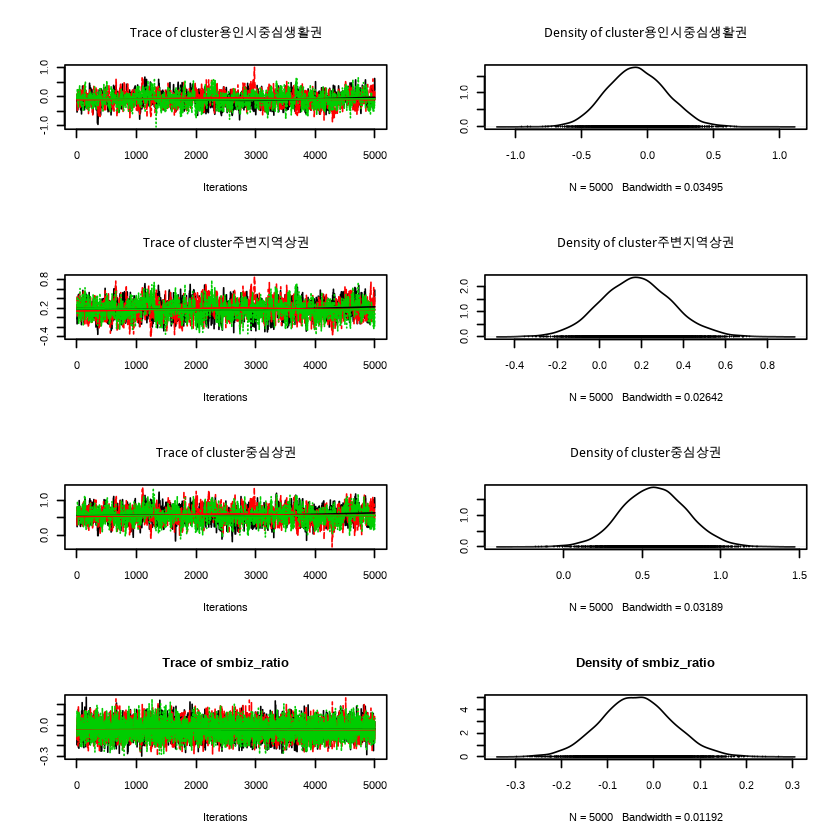

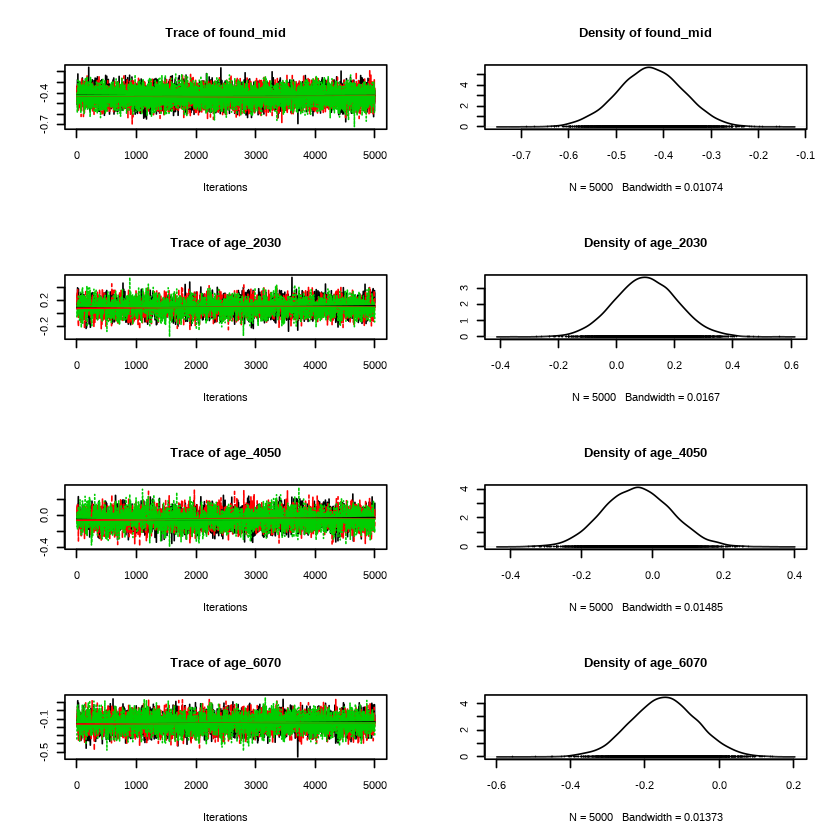

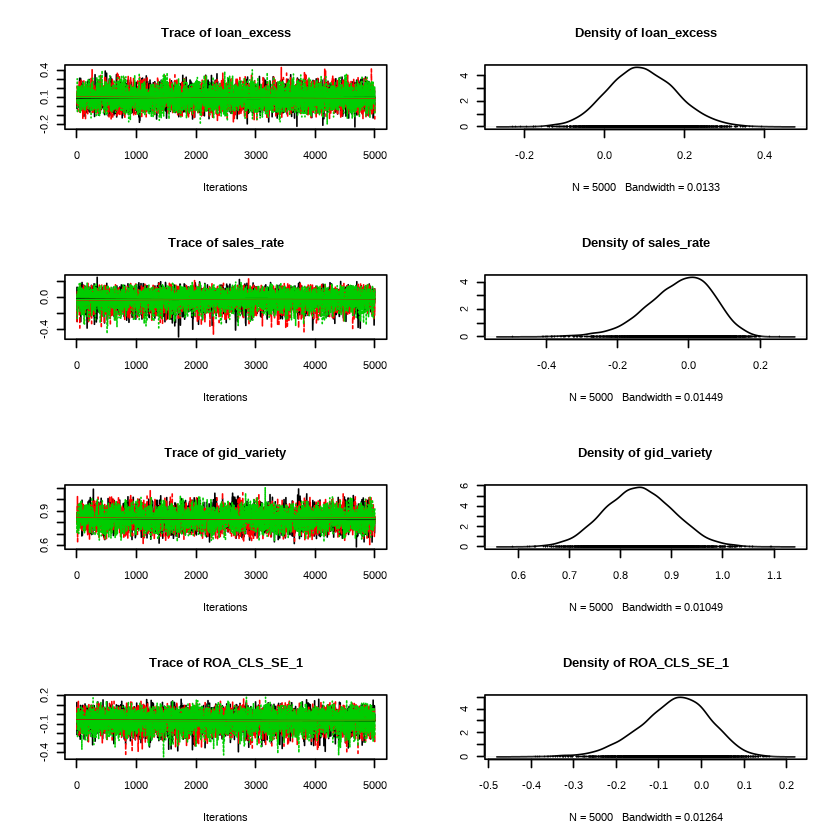

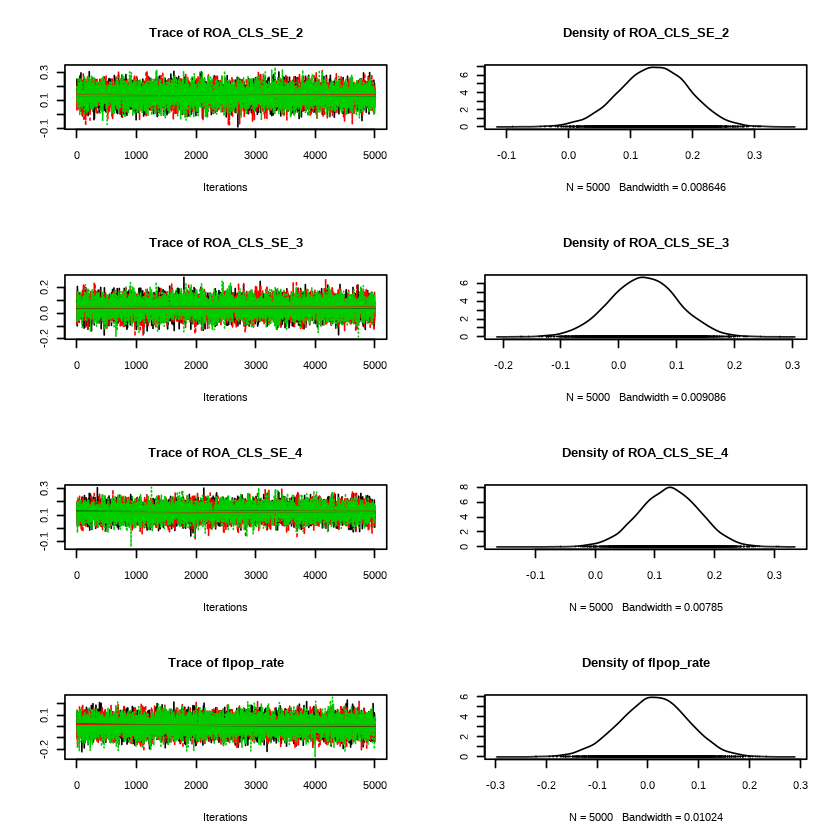

In [15]:
colnames(chain1$samples$beta)=colnames(chain2$samples$beta)=colnames(chain3$samples$beta)=row.names(chain1$summary.results)[1:17]
beta.samples <- mcmc.list(chain1$samples$beta,
                          chain2$samples$beta,
                         chain3$samples$beta)
n <- beta.samples[[1]] %>% ncol()
plot(beta.samples[ ,2:n]) 

- Trace 및 Density 보면 각 변수가 모두 수렴했다고 볼 수 있음

In [16]:
## Beta 계수 확인

beta.samples.matrix <- rbind(chain1$samples$beta,
                             chain2$samples$beta,
                            chain3$samples$beta)
colnames(beta.samples.matrix) <- colnames(chain1$X)
coef<-round(t(apply(beta.samples.matrix, 2, quantile, c(0.5, 0.025, 0.975))),5)  %>% as.data.frame()
coef

,50%,2.5%,97.5%
,<dbl>,<dbl>,<dbl>
(Intercept),-0.83123,-1.13797,-0.55232
cluster용인시중심생활권,-0.08454,-0.50526,0.36288
cluster주변지역상권,0.17627,-0.15274,0.52368
cluster중심상권,0.57610,0.17945,0.98500
smbiz_ratio,-0.03825,-0.18786,0.11912
found_mid,-0.42823,-0.56528,-0.29366
age_2030,0.10123,-0.10808,0.31656
age_4050,-0.04345,-0.22538,0.14693
age_6070,-0.14830,-0.32222,0.02532


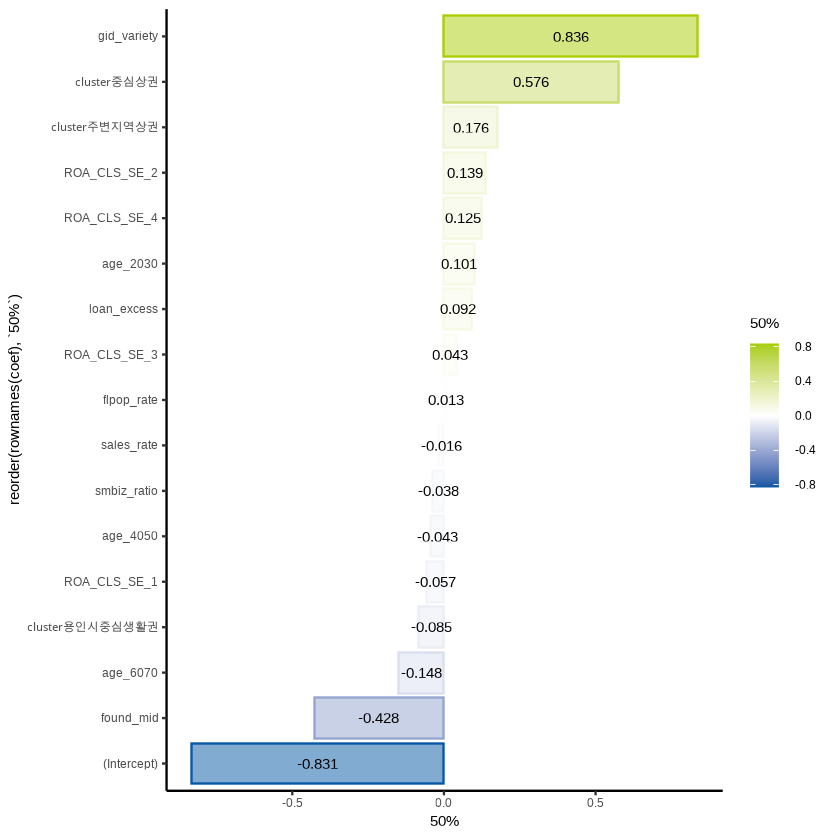

In [17]:
coef %>% ggplot(aes(x=reorder(rownames(coef), `50%`),
                                        y=`50%`,
                                        fill=`50%`,
                                        color=`50%`)) + 
    geom_bar(stat="identity", position="identity",alpha = 0.5) +
    coord_flip() + 
    scale_fill_gradient2(mid = "white",
                         low = "#0057a3",
                         high = "#a9cd07",
                         midpoint = 0, 
                         limit = c(min(coef$`50%`),
                                   max(coef$`50%`))) + 
    theme_classic() + 
    scale_color_gradient2(mid = "white",
                          low = "#0057a3",
                          high = "#a9cd07",
                          midpoint = 0, 
                          limit = c(min(coef$`50%`),
                                    max(coef$`50%`))) +
    geom_text(aes(label = round(coef[,1],3)), position=position_stack(vjust=0.5), color = 'black', size = 4)

- delta ( used for logistic regression: inflated zero)

In [18]:
colnames(chain1$samples$delta)=colnames(chain2$samples$delta)=colnames(chain3$samples$delta)=row.names(chain1$summary.results)[18:23]

delta.samples <- mcmc.list(chain1$samples$delta,
                          chain2$samples$delta,
                          chain3$samples$delta)

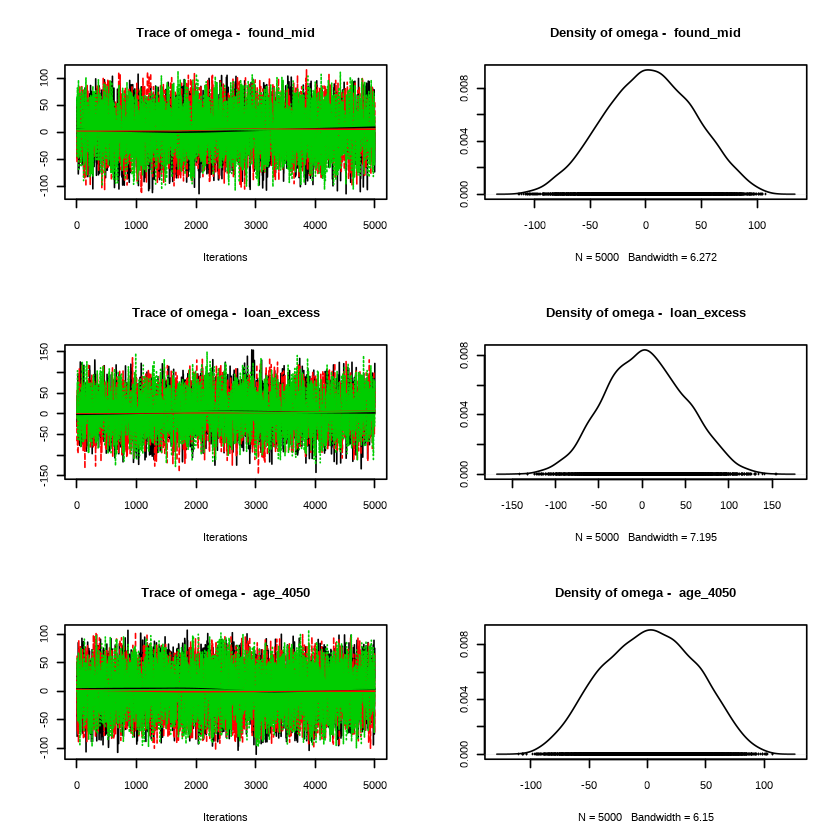

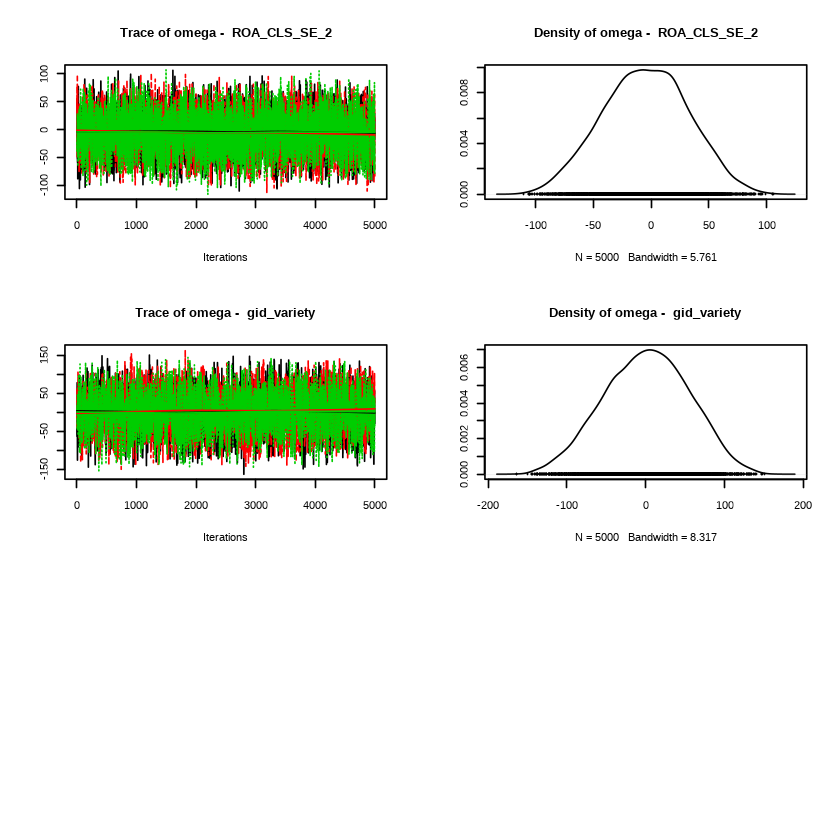

In [19]:
plot(delta.samples[ ,2:6]) 

- Trace 및 Density 보면 각 변수가 모두 수렴했다고 볼 수 있음

In [20]:
## Delta 계수 확인

delta.samples.matrix <- rbind(chain1$samples$delta,
                             chain2$samples$delta,
                             chain3$samples$delta)

inf_matrix_delta <- round(t(apply(delta.samples.matrix, 2, quantile, c(0.5, 0.025, 0.975))),5)
rownames(inf_matrix_delta)<-rownames(chain1$summary.results)[(n+3):length(rownames(chain1$summary.results))-2]
inf_matrix_delta

,50%,2.5%,97.5%
omega - (Intercept),-342.26158,-513.38265,-179.42927
omega - found_mid,3.59430,-75.77721,81.22075
omega - loan_excess,3.01440,-84.37575,94.89291
omega - age_4050,2.05429,-73.38610,75.53731
omega - ROA_CLS_SE_2,-4.56719,-77.51695,65.65194
omega - gid_variety,2.33921,-104.62691,101.59234


#### 5. 지역(격자) 추출 예시 
- 업종 다양성(gid_variety), 2030대 카드 사용 비율(age_2030)은 높고, 성숙기 사업체 비율(foun_mid)는 낮은 격자 추출
- 분위수를 통해 확인

In [21]:
## 분위수(Quantile)값으로 예시 추출

data %>% filter(gid_variety > quantile(gid_variety,p=.75) & 
                 age_2030>quantile(age_2030,p=.75) & 
                found_mid<quantile(found_mid,p=.25) &
                cluster == "중심상권")

gid,Y_youth_count,Y_stable,smbiz_ratio,found_mid,age_2030,age_4050,age_6070,loan_excess,sales_rate,gid_variety,ROA_CLS_SE_1,ROA_CLS_SE_2,ROA_CLS_SE_3,ROA_CLS_SE_4,flpop_rate,cluster,long,lat
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>
다사61bb22aa,6,151762,0.6166008,0.5968379,34.32,50.17,5.83,0.8135593,-0.134243043,11,0,0,1,2,0.003150101,중심상권,127.2222,37.27522
다사65ab24ba,13,56866,0.6030534,0.5877863,37.29,42.77,6.14,0.8947368,-0.003312593,11,0,1,2,3,-0.079836827,중심상권,127.0556,37.32429
다사72ab14bb,14,55783,0.5594406,0.2307692,47.78,36.92,3.74,0.8548387,-0.276982101,11,0,0,4,2,-0.161282533,중심상권,127.1718,37.20523


In [22]:
## 좌표 계산

map_merged_16 %>% filter(gid == "다사65ab24ba") %>% select(long, lat)

long,lat
<dbl>,<dbl>
127.1078,37.31884
127.1078,37.32109
127.1106,37.32110
127.1106,37.31885
127.1078,37.31884


In [23]:
leaflet(map_merged_16) %>% 
  setView(lng = 127.1092 , lat = 37.31997, zoom = 15.5) %>% 
  addProviderTiles('OpenStreetMap.Mapnik') %>% 
  addRectangles(
    lng1=127.1078, lat1 = 37.31884,
    lng2=127.1106, lat2 = 37.32110,
    fillColor = "#a9cd07", color ='#014700') %>%  
  addRectangles(
    lng1=127.1078, lat1 = 37.32109,
    lng2=127.1106, lat2 = 37.31885,
    fillColor = "#a9cd07", color ='#014700')  

HTML widgets cannot be represented in plain text (need html)

- 기흥구 보정동